# Constructing Morphological Networks from Overture Maps

In this notebook, we'll walk through the following workflow:

1. **Data Preparation**: Loading and processing street segments and building data from Overture Maps
2. **Space Division**: Creating morphological tessellations to represent private spaces
3. **Network Creation**: Generating different types of morphological networks:
   - Private-to-private connections (between adjacent private spaces)
   - Public-to-public connections (between street segments)
   - Private-to-public connections (between private spaces and streets)
4. **Graph Conversion**: Converting spatial networks to graph representations using PyTorch Geometric
5. **Visualization**: Exploring different ways to visualize the morphological networks

These graph representations enable various analyses of urban form, including connectivity studies, accessibility measures, and graph-based machine learning for urban analytics.

## 1. Setup and Environment

In [1]:
import numpy as np
from shapely import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import city2graph

# Configure matplotlib for better visualizations
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

## 2. Data Loading and Preparation

We'll work with data from Liverpool, UK, including building footprints and road network segments. These data are stored as GeoJSON files. `area` accepts either bbox or Polygon in WGS84.

In [2]:
"""
bbox = [-3.090173,53.355487,-2.917138,53.465587] # Liverpool city centre
city2graph.load_overture_data(area=bbox,
                              types=["segment", "building", "connector"],
                              output_dir=".",
                              prefix="liverpool_",
                              save_to_file=True,
                              return_data=False)
"""

'\nbbox = [-3.090173,53.355487,-2.917138,53.465587] # Liverpool city centre\ncity2graph.load_overture_data(area=bbox,\n                              types=["segment", "building", "connector"],\n                              output_dir=".",\n                              prefix="liverpool_",\n                              save_to_file=True,\n                              return_data=False)\n'

In [3]:
# Load GeoJSON files
buildings_gdf = gpd.read_file("liverpool_building.geojson")
segments_gdf = gpd.read_file("liverpool_segment.geojson")
connectors_gdf = gpd.read_file("liverpool_connector.geojson")

# Convert to British National Grid (EPSG:27700)
buildings_gdf = buildings_gdf.to_crs(epsg=27700)
segments_gdf = segments_gdf.to_crs(epsg=27700)
connectors_gdf = connectors_gdf.to_crs(epsg=27700)

print(f"Loaded {len(buildings_gdf)} buildings, {len(segments_gdf)} segments, and {len(connectors_gdf)} connectors")

Loaded 132972 buildings, 37474 segments, and 47367 connectors


## 3. Street Network Processing

`city2graph` offers functions that can process and clean up the original segments from Overture Maps. Eventually, `barrier_geometry` stores the ones not considered as tunnels and/or bridges.

In [4]:
# Filter road segments and process them to handle tunnels
segments_gdf = segments_gdf[segments_gdf["subtype"] == "road"].copy()

# Create barrier_geometry column by processing each segment (excluding tunnels)
segments_gdf = city2graph.process_overture_segments(segments_gdf=segments_gdf,
                                                    get_barriers=True,
                                                    connectors_gdf=connectors_gdf)

In [5]:
segments_gdf

,id,theme,version,sources,subtype,class,names,connectors,routes,subclass,...,road_flags,speed_limits,width_rules,geometry,barrier_mask,connector_mask,split_from,split_to,length,barrier_geometry
0,08a19510e8107fff04697f40f0ddc06f_1,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,service,"{ ""primary"": ""Mill Yard"", ""common"": null, ""rul...","[ { ""connector_id"": ""08f19510e8100b2a0469ff4ef...",None,None,...,None,None,None,"LINESTRING (327542.5 384889.719, 327513.406 38...","[[0.0, 1.0]]","[0.0, 1.0]",0.000000,1.000000,51.397961,"LINESTRING (327542.5 384889.719, 327513.406 38..."
1,08b19510e8122fff046d7f4c02aecabe_1,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,service,None,"[ { ""connector_id"": ""08f19510e81226f30469764b8...",None,None,...,None,None,None,"LINESTRING (327537.684 384958.392, 327539.57 3...","[[0.0, 1.0]]","[0.0, 1.0]",0.000000,1.000000,19.845172,"LINESTRING (327537.684 384958.392, 327539.57 3..."
2,08919510e813ffff047bf35198934015_1,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,residential,"{ ""primary"": ""Torrington Drive"", ""common"": nul...","[ { ""connector_id"": ""08f19510e8126828047bf3650...",None,None,...,None,None,None,"LINESTRING (327582.254 385030.873, 327515.969 ...","[[0.0, 1.0]]","[0.0, 1.0]",0.000000,1.000000,66.305155,"LINESTRING (327582.254 385030.873, 327515.969 ..."
3,08719510e8ffffff046977507971e203_1,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,residential,"{ ""primary"": ""Torrington Drive"", ""common"": nul...","[ { ""connector_id"": ""08f19510e889990a046bff6df...",None,None,...,None,None,None,"LINESTRING (327598.23 385078.832, 327598.23 38...","[[0.0, 1.0]]","[0.0, 0.389628677, 1.0]",0.000000,0.389629,46.102943,"LINESTRING (327598.23 385078.832, 327598.23 38..."
4,08719510e8ffffff046977507971e203_2,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,residential,"{ ""primary"": ""Torrington Drive"", ""common"": nul...","[ { ""connector_id"": ""08f19510e889990a046bff6df...",None,None,...,None,None,None,"LINESTRING (327552.279 385078.499, 327531.933 ...","[[0.0, 1.0]]","[0.0, 0.389628677, 1.0]",0.389629,1.000000,72.222392,"LINESTRING (327552.279 385078.499, 327531.933 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62111,08a195115821ffff046bdc86d642d4a4_1,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,footway,None,"[ { ""connector_id"": ""08f1951158218035046bde85f...",None,None,...,None,None,None,"LINESTRING (339134.192 396946.401, 339136.654 ...","[[0.0, 1.0]]","[0.0, 1.0]",0.000000,1.000000,42.962781,"LINESTRING (339134.192 396946.401, 339136.654 ..."
62112,08a195115821ffff047dbe9d1ace06c6_1,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,residential,"{ ""primary"": ""Falcon Hey"", ""common"": null, ""ru...","[ { ""connector_id"": ""08f195115821946c047daf91e...",None,None,...,None,None,None,"LINESTRING (339154.019 396904.231, 339178.372 ...","[[0.0, 1.0]]","[0.0, 1.0]",0.000000,1.000000,38.102616,"LINESTRING (339154.019 396904.231, 339178.372 ..."
62113,089195115823ffff047faeaea765e525_1,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,residential,None,"[ { ""connector_id"": ""08f195115821946c047daf91e...",None,None,...,None,None,None,"LINESTRING (339154.019 396904.231, 339154.046 ...","[[0.0, 1.0]]","[0.0, 1.0]",0.000000,1.000000,134.245387,"LINESTRING (339154.019 396904.231, 339154.046 ..."
62114,089195115823ffff047dbeb9eed6552e_1,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,residential,"{ ""primary"": ""Falcon Hey"", ""common"": null, ""ru...","[ { ""connector_id"": ""08f195115820a4c5047dbfa84...",None,None,...,None,None,None,"LINESTRING (339192.026 396906.902, 339212.31 3...","[[0.0, 1.0]]","[0.0, 1.0]",0.000000,1.000000,60.09444

In [6]:
n,e = city2graph.segments_to_graph(segments_gdf)

In [7]:
n.head()

,geometry
node_id,
0,POINT (327542.5 384889.719)
1,POINT (327537.684 384958.392)
2,POINT (327582.254 385030.873)
3,POINT (327598.23 385078.832)
4,POINT (327552.279 385078.499)


In [8]:
e.head()

,,id,theme,version,sources,subtype,class,names,connectors,routes,subclass,...,road_flags,speed_limits,width_rules,geometry,barrier_mask,connector_mask,split_from,split_to,length,barrier_geometry
from_node_id,to_node_id,,,,,,,,,,,,,,,,,,,,,
0,40923,08a19510e8107fff04697f40f0ddc06f_1,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,service,"{ ""primary"": ""Mill Yard"", ""common"": null, ""rul...","[ { ""connector_id"": ""08f19510e8100b2a0469ff4ef...",None,None,...,None,None,None,"LINESTRING (327542.5 384889.719, 327513.406 38...","[[0.0, 1.0]]","[0.0, 1.0]",0.000000,1.000000,51.397961,"LINESTRING (327542.5 384889.719, 327513.406 38..."
1,40924,08b19510e8122fff046d7f4c02aecabe_1,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,service,None,"[ { ""connector_id"": ""08f19510e81226f30469764b8...",None,None,...,None,None,None,"LINESTRING (327537.684 384958.392, 327539.57 3...","[[0.0, 1.0]]","[0.0, 1.0]",0.000000,1.000000,19.845172,"LINESTRING (327537.684 384958.392, 327539.57 3..."
2,40925,08919510e813ffff047bf35198934015_1,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,residential,"{ ""primary"": ""Torrington Drive"", ""common"": nul...","[ { ""connector_id"": ""08f19510e8126828047bf3650...",None,None,...,None,None,None,"LINESTRING (327582.254 385030.873, 327515.969 ...","[[0.0, 1.0]]","[0.0, 1.0]",0.000000,1.000000,66.305155,"LINESTRING (327582.254 385030.873, 327515.969 ..."
3,4,08719510e8ffffff046977507971e203_1,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,residential,"{ ""primary"": ""Torrington Drive"", ""common"": nul...","[ { ""connector_id"": ""08f19510e889990a046bff6df...",None,None,...,None,None,None,"LINESTRING (327598.23 385078.832, 327598.23 38...","[[0.0, 1.0]]","[0.0, 0.389628677, 1.0]",0.000000,0.389629,46.102943,"LINESTRING (327598.23 385078.832, 327598.23 38..."
4,40925,08719510e8ffffff046977507971e203_2,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,residential,"{ ""primary"": ""Torrington Drive"", ""common"": nul...","[ { ""connector_id"": ""08f19510e889990a046bff6df...",None,None,...,None,None,None,"LINESTRING (327552.279 385078.499, 327531.933 ...","[[0.0, 1.0]]","[0.0, 0.389628677, 1.0]",0.389629,1.000000,72.222392,"LINESTRING (327552.279 385078.499, 327531.933 ..."


In [9]:
G = city2graph.gdf_to_nx(n, e)

In [10]:
reconstructed_n, reconstructed_e = city2graph.nx_to_gdf(G)

In [11]:
G_ = city2graph.gdf_to_nx(reconstructed_n, reconstructed_e)

In [12]:
reconstructed_n, reconstructed_e = city2graph.nx_to_gdf(G_)

In [13]:
n_, e_ = city2graph.dual_graph((n, e), keep_original_geom=True, edge_id_col="id")

In [14]:
print(f"Original graph has {len(n)} nodes and {len(e)} edges")
print(n.geometry.head())
print(e.geometry.head())

print(f"Dual graph has {len(n_)} nodes and {len(e_)} edges")
print(n_.geometry.head())
print(e_.geometry.head())

Original graph has 47099 nodes and 62111 edges
node_id
0      POINT (327542.5 384889.719)
1    POINT (327537.684 384958.392)
2    POINT (327582.254 385030.873)
3     POINT (327598.23 385078.832)
4    POINT (327552.279 385078.499)
Name: geometry, dtype: geometry
from_node_id  to_node_id
0             40923         LINESTRING (327542.5 384889.719, 327513.406 38...
1             40924         LINESTRING (327537.684 384958.392, 327539.57 3...
2             40925         LINESTRING (327582.254 385030.873, 327515.969 ...
3             4             LINESTRING (327598.23 385078.832, 327598.23 38...
4             40925         LINESTRING (327552.279 385078.499, 327531.933 ...
Name: geometry, dtype: geometry
Dual graph has 62104 nodes and 121469 edges
id
08a19510e8107fff04697f40f0ddc06f_1    LINESTRING (327542.5 384889.719, 327513.406 38...
08919510e813ffff046b735db4284e53_1    LINESTRING (327592.637 384886.417, 327564.306 ...
08b19510e8122fff046d7f4c02aecabe_1    LINESTRING (327537.684 384958.

<Axes: >

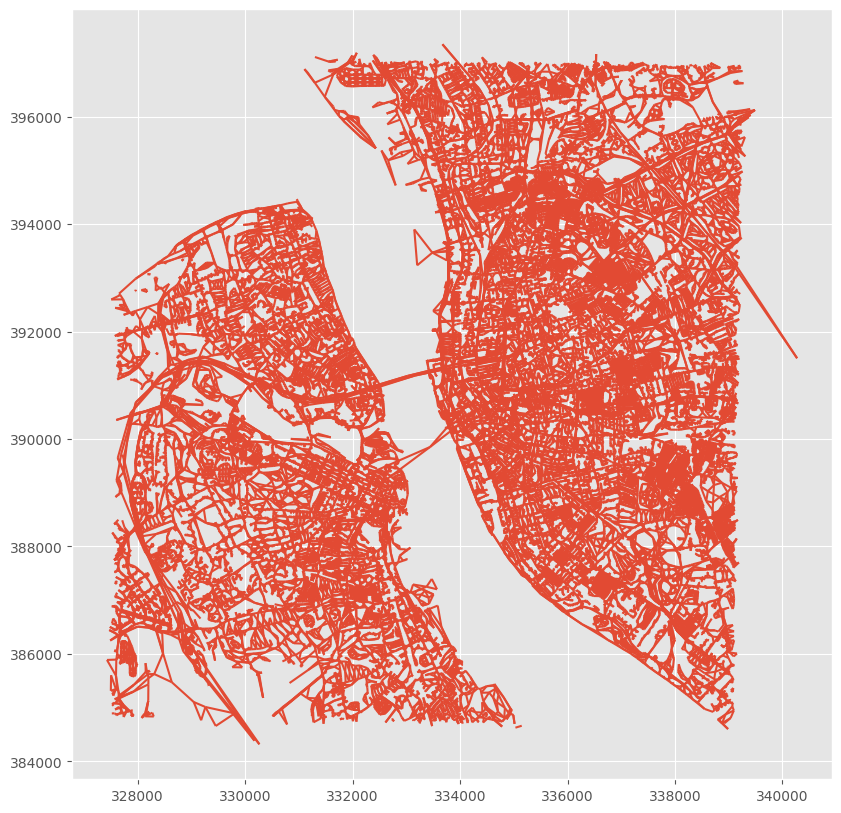

In [15]:
e_.geometry.plot()

## 4. Create Morphological Network
Based on the preprocessed segments and buildings, **a morphological network** is created by the following process:

<div align="center">
    <img src="../_static/morph_net_process.png" alt="City2Graph Logo" width="1000"/>
</div>

Morphological network is a heterogenous graph where all the spaces in cities are holistically represented as nodes. 

In this representation, the topological connections between public and private spaces can be captured. Unlike street network and contiguity matrix of built environment, morphological network can accomodate any of the charactors for urban forms and functions, such as POIs, land-use, street types, and etc. It will be a foundation for spatially-explicit GeoAI by graph representation learning, keeping the characters as node attributes.

There are three types of connections as edges: public-to-public, private-to-private, and private-to-public. Public-to-public connections are dual representation of street networks. Private-to-private shows the contiguities between enclosed tessellations as plot systems. Private-to-public can identify the adjacency between public and private spaces.

`city2graph.morphological_graph` can process the creation of morphological network as a dictionary of `gpd.GeoDataFrame` consisting of `['tessellation', 'segments', 'buildings', 'private_to_private', 'public_to_public', 'private_to_public']`. Post-processing, such as mapping POIs to private spaces, can be done accordingly.

In [16]:
# Get all unique geometry types in the barrier_geometry column
geometry_types = segments_gdf["barrier_geometry"].geom_type.value_counts()
print("Geometry types in barrier_geometry column:")
print(geometry_types)

# Also show the total count
print(f"\nTotal geometries: {len(segments_gdf['barrier_geometry'])}")

# Check for any null values
null_count = segments_gdf["barrier_geometry"].isnull().sum()
print(f"Null values: {null_count}")

Geometry types in barrier_geometry column:
LineString         61455
MultiLineString      205
Name: count, dtype: int64

Total geometries: 62116
Null values: 456


In [17]:
center_point = gpd.GeoSeries([Point((-2.9879004, 53.4062724))], crs='EPSG:4326').to_crs(epsg=27700)

morpho_nodes, morpho_edges = city2graph.morphological_graph(
    buildings_gdf=buildings_gdf,
    segments_gdf=segments_gdf,
    center_point=center_point,
    distance=500,
    clipping_buffer=300,
    primary_barrier_col='barrier_geometry',
    contiguity="queen",
    keep_buildings=True,
    )

/Users/yutasato/Projects/Liverpool/city2graph/city2graph/morphology.py:1129: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  return libpysal.weights.Queen.from_dataframe(gdf)
/Users/yutasato/Projects/Liverpool/city2graph/.venv/lib/python3.13/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


In [18]:
morpho_nodes.keys()

dict_keys(['private', 'public'])

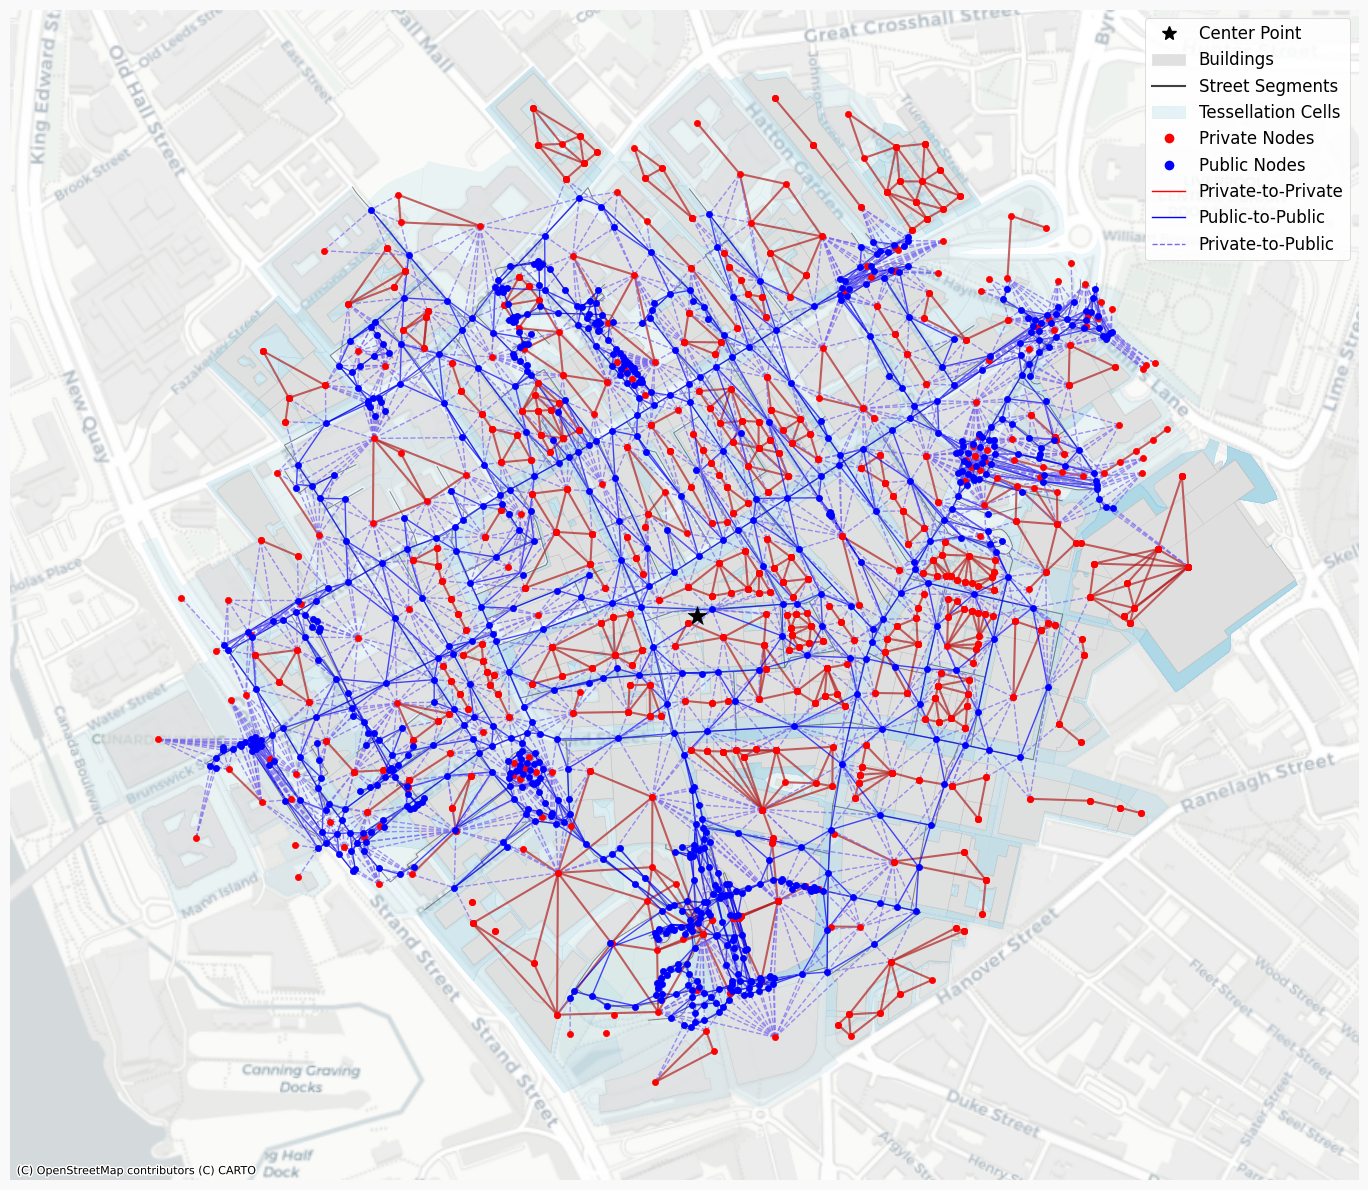

In [19]:
# Set up the figure with a nice size and background
fig, ax = plt.subplots(figsize=(14, 12), facecolor='#f9f9f9')

# Plot central point
ax.scatter(center_point.x, center_point.y, color='black', marker='*', s=200, zorder=5, label='Center Point')

# Plot background elements with improved styling
morpho_nodes["private"].plot(ax=ax, color='#ADD8E6', edgecolor='#87CEEB', linewidth=0.2, alpha=0.2)
morpho_nodes["private"]["building_geometry"].plot(ax=ax, color='#e0e0e0', edgecolor='#c0c0c0', linewidth=0.3, alpha=0.7)
morpho_nodes["public"].plot(ax=ax, color='#404040', linewidth=0.7, alpha=0.6)

# Plot the three network types with distinctive styles
morpho_edges[('private', 'touched_to', 'private')].plot(ax=ax, color='#B22222', linewidth=1.5, alpha=0.7)
morpho_edges[('public', 'connected_to', 'public')].plot(ax=ax, color='#0000FF', linewidth=1.0, alpha=0.7)
morpho_edges[('private', 'faced_to', 'public')].plot(ax=ax, color='#7B68EE', linewidth=1.0, alpha=0.7, linestyle='--')

# Add nodes: private nodes from tessellation centroids (red) and public nodes as midpoints of segments (blue)
private_nodes = morpho_nodes["private"].centroid
ax.scatter(private_nodes.x, private_nodes.y, color='red', s=20, zorder=10, label='Private Spaces')

public_nodes = morpho_nodes["public"].geometry.apply(lambda geom: geom.interpolate(0.5, normalized=True))
ax.scatter(public_nodes.x, public_nodes.y, color='blue', s=20, zorder=10, label='Public Spaces')

# Create a legend with clear labels
legend_elements = [
    plt.Line2D([0], [0], color='black', marker='*', linestyle='None', markersize=10, label='Center Point'),
    plt.Rectangle((0, 0), 1, 1, color='#e0e0e0', label='Buildings'),
    plt.Line2D([0], [0], color='#404040', lw=1.5, label='Street Segments'),
    plt.Rectangle((0, 0), 1, 1, color='#ADD8E6', alpha=0.3, label='Tessellation Cells'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, linestyle='None', label='Private Nodes'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, linestyle='None', label='Public Nodes'),
    plt.Line2D([0], [0], color='red', lw=1, label='Private-to-Private'),
    plt.Line2D([0], [0], color='blue', lw=1, label='Public-to-Public'),
    plt.Line2D([0], [0], color='#7B68EE', lw=1, linestyle='--', label='Private-to-Public'),
]

# Position the legend inside the plot (upper right)
ax.legend(handles=legend_elements, loc='upper right', 
          frameon=True, facecolor='white', framealpha=0.9, fontsize=12)

# Add title and remove axes
ax.set_axis_off()

# Add basemap from Stamen Terrain below everything else
cx.add_basemap(ax, crs='EPSG:27700', source=cx.providers.CartoDB.Positron, alpha=1)

plt.tight_layout()
plt.show()

In [20]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
# Primal graph nodes
nodes = gpd.GeoDataFrame(
    {"node_id": [0, 1, 2]},
    geometry=[Point(0, 0), Point(1, 1), Point(1, 0)],
    crs="EPSG:32633").set_index("node_id")
# Primal graph edges
edges = gpd.GeoDataFrame(
    {"edge_id": ["a", "b"]},
    geometry=[LineString([(0, 0), (1, 1)]), LineString([(1, 1), (1, 0)])],
    crs="EPSG:32633").set_index(pd.MultiIndex.from_tuples([(0, 1), (1, 2)]))
# Convert to dual graph
dual_nodes, dual_edges = city2graph.dual_graph(
    (nodes, edges), edge_id_col="edge_id", keep_original_geom=True
    )


In [21]:
import networkx as nx
# Create a simple graph with spatial attributes
G = nx.Graph(is_hetero=False, crs="EPSG:4326")
G.add_node(0, pos=(0, 0), population=100, geometry=Point(0,0))
G.add_node(1, pos=(1, 1), population=200, geometry=Point(1,1))
G.add_edge(0, 1, weight=1.5, geometry=LineString([(0, 0), (1, 1)]))

# Convert back to GeoDataFrames
nodes_gdf, edges_gdf = city2graph.nx_to_gdf(G)
print(nodes_gdf)
print(edges_gdf)


   population     geometry
0         100  POINT (0 0)
1         200  POINT (1 1)
     weight               geometry
0 1     1.5  LINESTRING (0 0, 1 1)


In [22]:
print(dual_edges)

                         angle                     geometry
from_edge_id to_edge_id                                    
a            b           135.0  LINESTRING (0.5 0.5, 1 0.5)


## 5. Convert to Graph Representations

Now we'll convert our morphological networks to graph representations using PyTorch Geometric for graph representation learning. As dependencies, `torch` and `torch_geometric` have to be installed in advance.

In [23]:
# Import PyTorch and PyTorch Geometric
import torch
try:
    import torch_geometric
    HAS_TORCH_GEOMETRIC = True
    print("PyTorch Geometric successfully imported")
    print(f"PyTorch version: {torch.__version__}")
    print(f"PyTorch Geometric version: {torch_geometric.__version__}")
except ImportError:
    print("PyTorch Geometric not installed. Graph functionality will be limited.")
    HAS_TORCH_GEOMETRIC = False

PyTorch Geometric successfully imported
PyTorch version: 2.7.0
PyTorch Geometric version: 2.6.1


### 5.1 Create a Homogeneous Graph

First, let's create a homogeneous graph of private spaces (tessellation cells) with their connections. `homogenous_graph` generates `torch_geometric.data.Data` with a single type of edges.

In [24]:
# Compute spatial features for tessellation cells
morpho_nodes["private"]["area"] = morpho_nodes["private"].geometry.area
morpho_nodes["private"]['perimeter'] = morpho_nodes["private"].geometry.length
morpho_nodes["private"]['compactness'] = 4 * np.pi * morpho_nodes["private"]["area"] / (morpho_nodes["private"]["perimeter"] ** 2)

# Show the feature distributions
morpho_nodes["private"][['area', 'perimeter', 'compactness']].describe()

,area,perimeter,compactness
count,1.342000e+03,1.342000e+03,1342.000000
mean,1.387670e+03,1.411316e+02,0.613203
std,2.801042e+03,1.109704e+02,0.149219
min,5.082198e-21,4.521472e-10,0.109664
25%,2.861228e+02,7.545969e+01,0.525861
50%,5.640226e+02,1.077236e+02,0.643373
75%,1.294717e+03,1.621755e+02,0.730044
max,2.342196e+04,7.911173e+02,0.987382


In [25]:
morpho_nodes["private"].index.name = "tess_id"
morpho_edges[('private', 'touched_to', 'private')].index.names = ['from_private_id', 'to_private_id']

In [26]:
private_graph = city2graph.gdf_to_pyg(nodes=morpho_nodes["private"],
                                      edges=morpho_edges[('private', 'touched_to', 'private')],
                                      node_feature_cols=['area', 'perimeter', 'compactness'],
                                      edge_feature_cols=None)

print(f"Created homogeneous graph with {private_graph.num_nodes} nodes and {private_graph.num_edges} edges")
print(f"Node features shape: {private_graph.x.shape}")

Created homogeneous graph with 1342 nodes and 620 edges
Node features shape: torch.Size([1342, 3])


In [27]:
n, e = city2graph.pyg_to_gdf(private_graph)

In [28]:
G = city2graph.gdf_to_nx(n, e)

In [29]:
G.nodes(data=True)[0]

{'area': 402.9433288574219,
 'perimeter': 5386.95703125,
 'compactness': 0.41693219542503357,
 'geometry': <POINT (334020.812 390464.156)>,
 '_original_index': '0_73736',
 'pos': (334020.8125, 390464.15625)}

In [30]:
list(G.nodes(data=True))[:5]

[(0,
  {'area': 402.9433288574219,
   'perimeter': 5386.95703125,
   'compactness': 0.41693219542503357,
   'geometry': <POINT (334020.812 390464.156)>,
   '_original_index': '0_73736',
   'pos': (334020.8125, 390464.15625)}),
 (1,
  {'area': 402.9433288574219,
   'perimeter': 5386.95703125,
   'compactness': 0.41693219542503357,
   'geometry': <POINT (334020.812 390464.156)>,
   '_original_index': '0_73736',
   'pos': (334020.8125, 390464.15625)}),
 (2,
  {'area': 162.77374267578125,
   'perimeter': 1005.6552124023438,
   'compactness': 0.4769691526889801,
   'geometry': <POINT (334054.812 390449.656)>,
   '_original_index': '0_73783',
   'pos': (334054.8125, 390449.65625)}),
 (3,
  {'area': 162.77374267578125,
   'perimeter': 1005.6552124023438,
   'compactness': 0.4769691526889801,
   'geometry': <POINT (334054.812 390449.656)>,
   '_original_index': '0_73783',
   'pos': (334054.8125, 390449.65625)}),
 (4,
  {'area': 150.89999389648438,
   'perimeter': 1456.8702392578125,
   'compac

In [31]:
G.graph

{'crs': <Projected CRS: EPSG:27700>
 Name: OSGB36 / British National Grid
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
 - bounds: (-9.01, 49.75, 2.01, 61.01)
 Coordinate Operation:
 - name: British National Grid
 - method: Transverse Mercator
 Datum: Ordnance Survey of Great Britain 1936
 - Ellipsoid: Airy 1830
 - Prime Meridian: Greenwich,
 'is_hetero': False,
 'node_types': [],
 'edge_types': [],
 'node_index_names': 'tess_id',
 'edge_index_names': FrozenList(['from_private_id', 'to_private_id']),
 'node_geom_cols': ['geometry'],
 'edge_geom_cols': ['geometry']}

In [32]:
n,e = city2graph.nx_to_gdf(G)

#### Test Graph Conversions

Let's test the round-trip conversions between different graph formats to ensure data integrity:

In [33]:
# Test round-trip conversion: PyG -> GDF -> NetworkX -> GDF
print("=== Testing Round-trip Conversions ===")

# Convert PyG to GDF
node_gdf, edge_gdf = city2graph.pyg_to_gdf(private_graph)
print(f"✓ PyG to GDF: {len(node_gdf)} nodes, {len(edge_gdf)} edges")

# Convert GDF to NetworkX
G = city2graph.gdf_to_nx(node_gdf, edge_gdf)
print(f"✓ GDF to NetworkX: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Convert NetworkX back to GDF
reconstructed_nodes, reconstructed_edges = city2graph.nx_to_gdf(G, nodes=True, edges=True)
print(f"✓ NetworkX to GDF: {len(reconstructed_nodes)} nodes, {len(reconstructed_edges)} edges")

# Verify index preservation
original_nodes = morpho_nodes["private"]
original_edges = morpho_edges[('private', 'touched_to', 'private')]

nodes_preserved = (
    original_nodes.index.name == reconstructed_nodes.index.name and
    len(original_nodes) == len(reconstructed_nodes)
)
edges_preserved = (
    original_edges.index.names == reconstructed_edges.index.names and
    len(original_edges) == len(reconstructed_edges)
)

# Create a detailed comparison table between original and reconstructed data
print("=== Index Structure Preservation Test ===\n")

# Node index comparison
print("NODE INDEX COMPARISON:")
print(f"Original node index name:      '{original_nodes.index.name}'")
print(f"Reconstructed node index name: '{reconstructed_nodes.index.name}'")
node_name_match = original_nodes.index.name == reconstructed_nodes.index.name
print(f"Index names match: {'✅' if node_name_match else '❌'}")

# Node count comparison
print(f"\nOriginal nodes count:      {len(original_nodes)}")
print(f"Reconstructed nodes count: {len(reconstructed_nodes)}")
node_count_match = len(original_nodes) == len(reconstructed_nodes)
print(f"Node counts match: {'✅' if node_count_match else '❌'}")

# Edge index comparison
print("\nEDGE INDEX COMPARISON:")
print(f"Original edge index names:      {original_edges.index.names}")
print(f"Reconstructed edge index names: {reconstructed_edges.index.names}")
edge_names_match = original_edges.index.names == reconstructed_edges.index.names
print(f"Index names match: {'✅' if edge_names_match else '❌'}")

# Edge count comparison
print(f"\nOriginal edges count:      {len(original_edges)}")
print(f"Reconstructed edges count: {len(reconstructed_edges)}")
edge_count_match = len(original_edges) == len(reconstructed_edges)
print(f"Edge counts match: {'✅' if edge_count_match else '❌'}")

# Summary
all_passed = node_name_match and node_count_match and edge_names_match and edge_count_match
print("\n=== SUMMARY ===")
if all_passed:
    print("✅ All tests passed! Data structure is preserved in round-trip conversion.")
else:
    print("❌ Some tests failed. Data structure is not fully preserved.")
    if not node_name_match:
        print("  - Node index names don't match")
    if not node_count_match:
        print("  - Node counts don't match")
    if not edge_names_match:
        print("  - Edge index names don't match")
    if not edge_count_match:
        print("  - Edge counts don't match")

if nodes_preserved and edges_preserved:
    print("\n✅ SUCCESS: Round-trip conversion preserves data structure!")
else:
    print("\n⚠️  WARNING: Some data structure changes detected in round-trip conversion")

=== Testing Round-trip Conversions ===
✓ PyG to GDF: 1342 nodes, 620 edges
✓ GDF to NetworkX: 1342 nodes, 620 edges
✓ NetworkX to GDF: 1342 nodes, 620 edges
=== Index Structure Preservation Test ===

NODE INDEX COMPARISON:
Original node index name:      'tess_id'
Reconstructed node index name: 'tess_id'
Index names match: ✅

Original nodes count:      1342
Reconstructed nodes count: 1342
Node counts match: ✅

EDGE INDEX COMPARISON:
Original edge index names:      ['from_private_id', 'to_private_id']
Reconstructed edge index names: ['from_private_id', 'to_private_id']
Index names match: ✅

Original edges count:      620
Reconstructed edges count: 620
Edge counts match: ✅

=== SUMMARY ===
✅ All tests passed! Data structure is preserved in round-trip conversion.

✅ SUCCESS: Round-trip conversion preserves data structure!


You can reconstruct (Geo)DataFrame by `pyg_to_gdf`. However, columns are not retained if they were not used for tensors.

### 5.2 Create a Heterogeneous Graph

Now, let's create a heterogeneous graph. In this example, the generated morphological network will be used as an axample. `heterogeneous_graph` provides `torch_geometric.data.HeteroData` object.

In [34]:
# Compute features for public spaces (street segments)
morpho_edges[('public', 'connected_to', 'public')]['length'] = morpho_edges[('public', 'connected_to', 'public')].geometry.length

# Show the feature distributions
morpho_edges[('public', 'connected_to', 'public')][['length']].describe()

,length
count,1425.000000
mean,22.059801
std,16.888244
min,0.737374
25%,8.961177
50%,16.868524
75%,31.713810
max,95.414142


In [35]:
morpho_edges[('private', 'faced_to', 'public')]

geometry
private_id public_id                                                   
0_73736    19328      LINESTRING (334020.81 390464.168, 334009.489 3...
           19330      LINESTRING (334020.81 390464.168, 334032.697 3...
           19329      LINESTRING (334020.81 390464.168, 334055.463 3...
0_73783    19329      LINESTRING (334054.803 390449.644, 334055.463 ...
           19497      LINESTRING (334054.803 390449.644, 334082.656 ...
...                                                                 ...
434_-7     31503      LINESTRING (334682.327 390468.037, 334687.444 ...
           31494      LINESTRING (334682.327 390468.037, 334665.54 3...
           31495      LINESTRING (334682.327 390468.037, 334649.144 ...
           31496      LINESTRING (334682.327 390468.037, 334656.479 ...
           31547      LINESTRING (334682.327 390468.037, 334618.189 ...

[2511 rows x 1 columns]

In [36]:
print("morpho_edges[('private', 'faced_to', 'public')].head(1)")
print(morpho_edges[('public', 'connected_to', 'public')].head(1))

print("morpho_edges[('private', 'faced_to', 'public')].head(1)")
print(morpho_edges[('private', 'faced_to', 'public')].head(1))

morpho_edges[('private', 'faced_to', 'public')].head(1)
                                angle  \
from_public_id to_public_id             
31537          31526         0.004668   

                                                                      geometry  \
from_public_id to_public_id                                                      
31537          31526         LINESTRING (334529.724 390678.966, 334494.549 ...   

                                length  
from_public_id to_public_id             
31537          31526         41.301099  
morpho_edges[('private', 'faced_to', 'public')].head(1)
                                                               geometry
private_id public_id                                                   
0_73736    19328      LINESTRING (334020.81 390464.168, 334009.489 3...


In [37]:
morpho_edges.keys()

dict_keys([('private', 'touched_to', 'private'), ('public', 'connected_to', 'public'), ('private', 'faced_to', 'public')])

In [38]:
hetero_graph = city2graph.gdf_to_pyg(morpho_nodes,
                                     morpho_edges,
                                     node_feature_cols={"private": ['area', 'perimeter', 'compactness'],
                                                        "public": ['length']})
hetero_graph

HeteroData(
  crs=EPSG:27700,
  private={
    x=[1342, 3],
    pos=[1342, 2],
  },
  public={
    x=[777, 1],
    pos=[777, 2],
  },
  (private, touched_to, private)={
    edge_index=[2, 620],
    edge_attr=[620, 0],
  },
  (public, connected_to, public)={
    edge_index=[2, 1425],
    edge_attr=[1425, 0],
  },
  (private, faced_to, public)={
    edge_index=[2, 2511],
    edge_attr=[2511, 0],
  }
)

In [39]:
# Create a NetworkX graph from GeoDataFrames
G = city2graph.gdf_to_nx(morpho_nodes, morpho_edges)

# Convert back to GeoDataFrames
reconstructed_nodes, reconstructed_edges = city2graph.nx_to_gdf(G)

# Test whether index structure and names are preserved in the round trip
print("=== Testing Index Preservation in Round Trip Conversion ===\n")

# Check node index preservation
print("Node index preservation:")
for node_type in morpho_nodes:
    original_index_name = morpho_nodes[node_type].index.name
    reconstructed_index_name = reconstructed_nodes[node_type].index.name
    original_length = len(morpho_nodes[node_type])
    reconstructed_length = len(reconstructed_nodes[node_type])
    
    print(f"  {node_type}:")
    print(f"    Original index name: {original_index_name}")
    print(f"    Reconstructed index name: {reconstructed_index_name}")
    print(f"    Original length: {original_length}")
    print(f"    Reconstructed length: {reconstructed_length}")
    print(f"    Index name preserved: {original_index_name == reconstructed_index_name}")
    print(f"    Length preserved: {original_length == reconstructed_length}")
    
    # Show first 5 values to compare
    print(f"    Original index (first 5): {morpho_nodes[node_type].index[:5].tolist()}")
    print(f"    Reconstructed index (first 5): {reconstructed_nodes[node_type].index[:5].tolist()}")
    print()

# Check edge index preservation
print("Edge index preservation:")
for edge_type in morpho_edges:
    original_index_names = morpho_edges[edge_type].index.names
    reconstructed_index_names = reconstructed_edges[edge_type].index.names
    original_length = len(morpho_edges[edge_type])
    reconstructed_length = len(reconstructed_edges[edge_type])
    
    print(f"  {edge_type}:")
    print(f"    Original index names: {original_index_names}")
    print(f"    Reconstructed index names: {reconstructed_index_names}")
    print(f"    Original length: {original_length}")
    print(f"    Reconstructed length: {reconstructed_length}")
    print(f"    Index names preserved: {original_index_names == reconstructed_index_names}")
    print(f"    Length preserved: {original_length == reconstructed_length}")
    print()

# Summary
node_names_preserved = all(morpho_nodes[node_type].index.name == reconstructed_nodes[node_type].index.name 
                          for node_type in morpho_nodes)
edge_names_preserved = all(morpho_edges[edge_type].index.names == reconstructed_edges[edge_type].index.names 
                          for edge_type in morpho_edges)
lengths_preserved = all(len(morpho_nodes[node_type]) == len(reconstructed_nodes[node_type]) 
                        for node_type in morpho_nodes) and \
                    all(len(morpho_edges[edge_type]) == len(reconstructed_edges[edge_type]) 
                        for edge_type in morpho_edges)

# Final result
if node_names_preserved and edge_names_preserved and lengths_preserved:
    print("✅ SUCCESS: All index structures preserved in round-trip conversion!")
else:
    print("⚠️ WARNING: Index structure changes detected in round-trip conversion")
    
    if not node_names_preserved:
        print("  - Node index names not preserved")
    if not edge_names_preserved:
        print("  - Edge index names not preserved")
    if not lengths_preserved:
        print("  - Data lengths not preserved")


=== Testing Index Preservation in Round Trip Conversion ===

Node index preservation:
  private:
    Original index name: tess_id
    Reconstructed index name: tess_id
    Original length: 1342
    Reconstructed length: 1342
    Index name preserved: True
    Length preserved: True
    Original index (first 5): ['0_73736', '0_73736', '0_73783', '0_73783', '1_73751']
    Reconstructed index (first 5): ['0_73736', '0_73736', '0_73783', '0_73783', '1_73751']

  public:
    Original index name: public_id
    Reconstructed index name: public_id
    Original length: 777
    Reconstructed length: 777
    Index name preserved: True
    Length preserved: True
    Original index (first 5): [31537, 31540, 31567, 31538, 31541]
    Reconstructed index (first 5): [31537, 31540, 31567, 31538, 31541]

Edge index preservation:
  ('private', 'touched_to', 'private'):
    Original index names: ['from_private_id', 'to_private_id']
    Reconstructed index names: ['from_private_id', 'to_private_id']
    Ori

In [40]:
reconstructed_edges[('private','touched_to','private')]

enclosure_index  \
from_private_id to_private_id                    
0_73736         0_73783                      0   
1_73751         1_73784                      1   
2_73754         2_73843                      2   
                2_73844                      2   
2_73842         2_73843                      2   
...                                        ...   
409_73966       409_73968                  409   
409_73967       409_73968                  409   
                409_73974                  409   
409_73968       409_73974                  409   
409_73973       409_73974                  409   

                                                                        geometry  
from_private_id to_private_id                                                     
0_73736         0_73783        LINESTRING (334020.81 390464.168, 334054.803 3...  
1_73751         1_73784        LINESTRING (334036.012 390526.347, 334074.295 ...  
2_73754         2_73843        LINESTRING (334023.16 390637.916, 334046.737 3...  
                2_73844        LINESTRING (334023.16 390637.916, 334080.487 3...  
2_73842         2_73843        LINESTRING (334043.634 390573.008, 334046.737 ...  
...                                                                          ...  
409_73966       409_73968      LINESTRING (334276.107 390827.458, 334270.95 3...  
409_73967       409_73968      LINESTRING (334297.481 390828.424, 334270.95 3...  
                409_73974      LINESTRING (334297.481 390828.424, 334314.114 ...  
409_73968       409_73974      LINESTRING (334270.95 390861.645, 334314.114 3...  
409_73973       409_73974      LINESTRING (334330.238 390820.617, 334314.114 ...  

[620 rows x 2 columns]

In [41]:
reconstructed_nodes["private"]

,geometry,enclosure_index,id,theme,type,version,sources,level,subtype,class,...,roof_material,roof_shape,roof_direction,roof_orientation,roof_color,roof_height,building_geometry,area,perimeter,compactness
tess_id,,,,,,,,,,,,,,,,,,,,,
0_73736,"POLYGON ((334073.913 390420.014, 334030.706 39...",0,08b195107366efff0200da8894411a2f,buildings,building,0.0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,commercial,commercial,...,None,None,NaN,NaN,None,NaN,POLYGON ((334042.1908190205 390476.62385118916...,5386.956798,402.943315,0.416932
0_73736,"POLYGON ((334073.913 390420.014, 334030.706 39...",0,08b1951073663fff0200a91edda792ab,buildings,building,0.0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,None,None,...,None,None,NaN,NaN,None,NaN,POLYGON ((334011.10273865896 390528.3299457993...,5386.956798,402.943315,0.416932
0_73783,"POLYGON ((334043.525 390481.046, 334080.22 390...",0,08b195107366efff0200da8894411a2f,buildings,building,0.0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,commercial,commercial,...,None,None,NaN,NaN,None,NaN,POLYGON ((334042.1908190205 390476.62385118916...,1005.655204,162.773739,0.476969
0_73783,"POLYGON ((334043.525 390481.046, 334080.22 390...",0,08b1951073663fff0200a91edda792ab,buildings,building,0.0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,None,None,...,None,None,NaN,NaN,None,NaN,POLYGON ((334011.10273865896 390528.3299457993...,1005.655204,162.773739,0.476969
1_73751,"POLYGON ((334032.01 390498.98, 334009.246 3905...",1,08b1951073660fff0200643aa416b427,buildings,building,0.0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,None,None,...,None,None,NaN,NaN,None,NaN,POLYGON ((334017.77182075544 390532.1648249346...,1456.870240,150.899993,0.803993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429_-11,"POLYGON ((334296.039 390014.009, 334296.039 39...",429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,981.410370,144.190861,0.593178
430_93872,"POLYGON ((334544.323 390486.491, 334542.194 39...",430,08b1951073202fff020084bc1cd8c664,buildings,building,0.0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,None,None,...,None,None,NaN,NaN,None,NaN,"POLYGON ((334501.1044164534 390487.9012165, 33...",7.604303,11.728495,0.694680
431_-10,"POLYGON ((334309.878 389995.391, 334324.085 39...",431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,585.994670,159.637359,0.288958


In [42]:
morpho_nodes['private']

,geometry,enclosure_index,id,theme,type,version,sources,level,subtype,class,...,roof_material,roof_shape,roof_direction,roof_orientation,roof_color,roof_height,building_geometry,area,perimeter,compactness
tess_id,,,,,,,,,,,,,,,,,,,,,
0_73736,"POLYGON ((334073.913 390420.014, 334030.706 39...",0,08b195107366efff0200da8894411a2f,buildings,building,0.0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,commercial,commercial,...,None,None,NaN,None,None,NaN,"POLYGON ((334042.191 390476.624, 334035.18 390...",5386.956798,402.943315,0.416932
0_73736,"POLYGON ((334073.913 390420.014, 334030.706 39...",0,08b1951073663fff0200a91edda792ab,buildings,building,0.0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,None,None,...,None,None,NaN,None,None,NaN,"POLYGON ((334011.103 390528.33, 333991.526 390...",5386.956798,402.943315,0.416932
0_73783,"POLYGON ((334043.525 390481.046, 334080.22 390...",0,08b195107366efff0200da8894411a2f,buildings,building,0.0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,commercial,commercial,...,None,None,NaN,None,None,NaN,"POLYGON ((334042.191 390476.624, 334035.18 390...",1005.655204,162.773739,0.476969
0_73783,"POLYGON ((334043.525 390481.046, 334080.22 390...",0,08b1951073663fff0200a91edda792ab,buildings,building,0.0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,None,None,...,None,None,NaN,None,None,NaN,"POLYGON ((334011.103 390528.33, 333991.526 390...",1005.655204,162.773739,0.476969
1_73751,"POLYGON ((334032.01 390498.98, 334009.246 3905...",1,08b1951073660fff0200643aa416b427,buildings,building,0.0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,None,None,...,None,None,NaN,None,None,NaN,"POLYGON ((334017.772 390532.165, 334016.849 39...",1456.870240,150.899993,0.803993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429_-11,"POLYGON ((334296.039 390014.009, 334296.039 39...",429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,981.410370,144.190861,0.593178
430_93872,"POLYGON ((334544.323 390486.491, 334542.194 39...",430,08b1951073202fff020084bc1cd8c664,buildings,building,0.0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,None,None,...,None,None,NaN,None,None,NaN,"POLYGON ((334501.104 390487.901, 334502.342 39...",7.604303,11.728495,0.694680
431_-10,"POLYGON ((334309.878 389995.391, 334324.085 39...",431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,585.994670,159.637359,0.288958


In [43]:
n,e = city2graph.nx_to_gdf(G)

In [44]:
n["public"]

,id,theme,version,sources,subtype,class,names,connectors,routes,subclass,...,road_flags,speed_limits,width_rules,geometry,barrier_mask,connector_mask,split_from,split_to,length,barrier_geometry
public_id,,,,,,,,,,,,,,,,,,,,,
31537,08a19510733affff047dff2416a8a354_1,transportation,0,"[ { ""property"": ""routes"", ""dataset"": ""OpenStre...",road,primary,"{ ""primary"": ""Dale Street"", ""common"": null, ""r...","[ { ""connector_id"": ""08f19510733a91090469d730d...","[ { ""name"": null, ""network"": null, ""ref"": ""A57...",None,...,None,"[ { ""min_speed"": null, ""max_speed"": { ""value"":...",None,"LINESTRING (334551.651 390692.461, 334507.796 ...","[[0.0, 1.0]]","[0.0, 1.0]",0.000000,1.000000,51.494328,LINESTRING (334551.6512018793 390692.460632196...
31540,08b19510733a9fff046bf23329390566_1,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,residential,None,"[ { ""connector_id"": ""08f19510733a9850046b8b365...",None,None,...,None,None,None,"LINESTRING (334559.562 390698.638, 334551.651 ...","[[0.0, 1.0]]","[0.0, 1.0]",0.000000,1.000000,10.036979,LINESTRING (334559.5620197588 390698.638003445...
31567,08819510733fffff046ffb475b10ad91_4,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,tertiary,"{ ""primary"": ""Crosshall Street"", ""common"": nul...","[ { ""connector_id"": ""08f195107322252a047baa5d5...",None,None,...,None,None,None,"LINESTRING (334555.826 390686.194, 334551.651 ...","[[0.0, 1.0]]","[0.0, 0.107903844, 0.306055242, 0.944006711, 1.0]",0.944007,1.000000,7.530033,LINESTRING (334555.8263629347 390686.194100369...
31538,08b19510733a9fff0469a634913e15d9_1,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,footway,None,"[ { ""connector_id"": ""08f19510733a9bae0469d337b...",None,crosswalk,...,None,None,None,"LINESTRING (334563.257 390690.854, 334563.257 ...","[[0.0, 1.0]]","[0.0, 0.700802358, 1.0]",0.000000,0.700802,8.771156,LINESTRING (334563.2574544175 390690.853719863...
31541,08b19510733a9fff046bfa35ba350c43_1,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,footway,None,"[ { ""connector_id"": ""08f19510733a9bae0469d337b...",None,crosswalk,...,None,None,None,"LINESTRING (334563.257 390690.854, 334563.257 ...","[[0.0, 1.0]]","[0.0, 0.534484894, 1.0]",0.000000,0.534485,8.616920,LINESTRING (334563.2574544175 390690.853719863...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30355,08819510733fffff047ff673ca41b368_2,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,pedestrian,"{ ""primary"": ""College Lane"", ""common"": null, ""...","[ { ""connector_id"": ""08f19510732ebd80047da34d4...",None,None,...,None,None,None,"LINESTRING (334618.459 390124.365, 334618.459 ...","[[0.0, 1.0]]","[0.0, 0.199883256, 0.271710621, 0.615778161, 0...",0.199883,0.271711,9.649489,LINESTRING (334618.4587840776 390124.365433023...
30361,08a19510732effff04698f60a4c1c2b8_1,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,pedestrian,"{ ""primary"": ""Peter's Lane"", ""common"": null, ""...","[ { ""connector_id"": ""08f19510732ecc4a047fe7648...",None,None,...,None,None,None,"LINESTRING (334632.85 390203.001, 334630.153 3...",[],"[0.0, 1.0]",0.000000,1.000000,79.944402,None
31536,08919510733bffff047fc3edc1bc41cf_3,transportation,0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,unclassified,"{ ""primary"": ""Cheapside"", ""common"": null, ""rul...","[ { ""connector_id"": ""08f19510733b155d047fe3c3d...",None,None,...,None,None,None,"LINESTRING (334451.639 390740.21, 334451.639 3...","[[0.0, 1.0]]","[0.0, 0.329012358, 0.590547438, 1.0]",0.590547,1.000000,93.484610,LINESTRING (334451.6385761947 390740.210018830...


In [45]:
e[('private',
  'touched_to',
  'private')]

enclosure_index  \
from_private_id to_private_id                    
0_73736         0_73783                      0   
1_73751         1_73784                      1   
2_73754         2_73843                      2   
                2_73844                      2   
2_73842         2_73843                      2   
...                                        ...   
409_73966       409_73968                  409   
409_73967       409_73968                  409   
                409_73974                  409   
409_73968       409_73974                  409   
409_73973       409_73974                  409   

                                                                        geometry  
from_private_id to_private_id                                                     
0_73736         0_73783        LINESTRING (334020.81 390464.168, 334054.803 3...  
1_73751         1_73784        LINESTRING (334036.012 390526.347, 334074.295 ...  
2_73754         2_73843        LINESTRING (334023.16 390637.916, 334046.737 3...  
                2_73844        LINESTRING (334023.16 390637.916, 334080.487 3...  
2_73842         2_73843        LINESTRING (334043.634 390573.008, 334046.737 ...  
...                                                                          ...  
409_73966       409_73968      LINESTRING (334276.107 390827.458, 334270.95 3...  
409_73967       409_73968      LINESTRING (334297.481 390828.424, 334270.95 3...  
                409_73974      LINESTRING (334297.481 390828.424, 334314.114 ...  
409_73968       409_73974      LINESTRING (334270.95 390861.645, 334314.114 3...  
409_73973       409_73974      LINESTRING (334330.238 390820.617, 334314.114 ...  

[620 rows x 2 columns]

In [46]:
n,e = city2graph.pyg_to_gdf(hetero_graph)

In [47]:
G = city2graph.gdf_to_nx(n, e)

In [48]:
G.nodes(data=True)[0]

{'area': 402.9433288574219,
 'perimeter': 5386.95703125,
 'compactness': 0.41693219542503357,
 'geometry': <POINT (334020.812 390464.156)>,
 'node_type': 'private',
 '_original_index': '0_73736',
 'pos': (334020.8125, 390464.15625)}

In [49]:
# Show 5 sample nodes of G with their data
sample_nodes = list(G.nodes(data=True))[:5]
for node, data in sample_nodes:
    print(f"Node: {node}")
    print(f"Data: {data}")
    print("-" * 50)

# Check if original attribute names are preserved
node_attrs = [attr for _, attrs in G.nodes(data=True) for attr in attrs.keys()]
unique_attrs = set(node_attrs)
print("\nUnique node attributes found:")
for attr in sorted(unique_attrs):
    print(f"  - {attr}")

# Check if we have the original feature names
expected_attrs = ['area', 'perimeter', 'compactness', 'length']
found_expected = [attr for attr in expected_attrs if attr in unique_attrs]
print(f"\nOriginal feature names preserved: {found_expected}")
if found_expected:
    print("✅ SUCCESS: Original attribute names are preserved!")
else:
    print("❌ ISSUE: Original attribute names not found")

Node: 0
Data: {'area': 402.9433288574219, 'perimeter': 5386.95703125, 'compactness': 0.41693219542503357, 'geometry': <POINT (334020.812 390464.156)>, 'node_type': 'private', '_original_index': '0_73736', 'pos': (334020.8125, 390464.15625)}
--------------------------------------------------
Node: 1
Data: {'area': 402.9433288574219, 'perimeter': 5386.95703125, 'compactness': 0.41693219542503357, 'geometry': <POINT (334020.812 390464.156)>, 'node_type': 'private', '_original_index': '0_73736', 'pos': (334020.8125, 390464.15625)}
--------------------------------------------------
Node: 2
Data: {'area': 162.77374267578125, 'perimeter': 1005.6552124023438, 'compactness': 0.4769691526889801, 'geometry': <POINT (334054.812 390449.656)>, 'node_type': 'private', '_original_index': '0_73783', 'pos': (334054.8125, 390449.65625)}
--------------------------------------------------
Node: 3
Data: {'area': 162.77374267578125, 'perimeter': 1005.6552124023438, 'compactness': 0.4769691526889801, 'geometr

In [50]:
print("morpho_nodes: ")
print(morpho_nodes)

print("morpho_edges: ")
print(morpho_edges)

hetero_graph = city2graph.gdf_to_pyg(morpho_nodes,
                                     morpho_edges,
                                     node_feature_cols={"private": ['area', 'perimeter', 'compactness'],
                                                        "public": ['length']})
G = city2graph.pyg_to_nx(hetero_graph)

reconstructed_nodes, reconstructed_edges = city2graph.nx_to_gdf(G)

print("reconstructed nodes: ")
print(reconstructed_nodes)

print("reconstructed edges: ")
print(reconstructed_edges)

morpho_nodes: 
{'private':                                                     geometry  enclosure_index  \
tess_id                                                                         
0_73736    POLYGON ((334073.913 390420.014, 334030.706 39...                0   
0_73736    POLYGON ((334073.913 390420.014, 334030.706 39...                0   
0_73783    POLYGON ((334043.525 390481.046, 334080.22 390...                0   
0_73783    POLYGON ((334043.525 390481.046, 334080.22 390...                0   
1_73751    POLYGON ((334032.01 390498.98, 334009.246 3905...                1   
...                                                      ...              ...   
429_-11    POLYGON ((334296.039 390014.009, 334296.039 39...              429   
430_93872  POLYGON ((334544.323 390486.491, 334542.194 39...              430   
431_-10    POLYGON ((334309.878 389995.391, 334324.085 39...              431   
432_-9     POLYGON ((334324.085 390019.606, 334328.754 39...              432   
4

In [51]:
hetero_graph = city2graph.gdf_to_pyg(morpho_nodes,
                                     morpho_edges,
                                     node_feature_cols={"private": ['area', 'perimeter', 'compactness'],
                                                        "public": ['length']})

G_hetero = city2graph.pyg_to_nx(hetero_graph)

reconstructed_nodes, reconstructed_edges = city2graph.nx_to_gdf(G_hetero)

In [52]:
reconstructed_nodes

{'private':             area    perimeter  compactness geometry
 None  402.943329  5386.957031     0.416932     None
 None  402.943329  5386.957031     0.416932     None
 None  162.773743  1005.655212     0.476969     None
 None  162.773743  1005.655212     0.476969     None
 None  150.899994  1456.870239     0.803993     None
 ...          ...          ...          ...      ...
 None  144.190857   981.410400     0.593178     None
 None   11.728495     7.604303     0.694680     None
 None  159.637360   585.994690     0.288958     None
 None  114.786263   344.115448     0.328197     None
 None  160.412292   925.695801     0.452067     None
 
 [1342 rows x 4 columns],
 'public':          length geometry
 None  51.494328     None
 None  10.036980     None
 None   7.530033     None
 None   8.771156     None
 None   8.616920     None
 ...         ...      ...
 None   9.649489     None
 None  79.944405     None
 None  93.484612     None
 None   7.639970     None
 None  59.712673     None
 
 

In [53]:
# Clean test of the fix
print("=== Testing Fixed Round-Trip Conversion ===")

# Step 1: Convert morphological data to NetworkX
print("Step 1: Converting to NetworkX...")
G_test = city2graph.gdf_to_nx(morpho_nodes, morpho_edges)
print(f"✓ NetworkX nodes: {G_test.number_of_nodes()}")
print(f"✓ NetworkX edges: {G_test.number_of_edges()}")

# Step 2: Convert NetworkX back to GeoDataFrames
print("\nStep 2: Converting back to GeoDataFrames...")
test_nodes, test_edges = city2graph.nx_to_gdf(G_test)
print(f"✓ Reconstructed node types: {list(test_nodes.keys())}")
print(f"✓ Reconstructed edge types: {list(test_edges.keys())}")

# Step 3: Check reconstruction success
print("\nStep 3: Checking reconstruction results...")
for edge_type, edge_gdf in test_edges.items():
    original_count = len(morpho_edges[edge_type])
    reconstructed_count = len(edge_gdf)
    success_rate = (reconstructed_count / original_count) * 100
    print(f"  {edge_type}: {reconstructed_count}/{original_count} ({success_rate:.1f}%)")

# Step 4: Focus on public-to-public edges
print("\nStep 4: Public-to-public edge analysis...")
original_pub_pub = morpho_edges[('public', 'connected_to', 'public')]
reconstructed_pub_pub = test_edges[('public', 'connected_to', 'public')]

print(f"Original: {len(original_pub_pub)} edges")
print(f"Reconstructed: {len(reconstructed_pub_pub)} edges")
print(f"Success rate: {len(reconstructed_pub_pub) / len(original_pub_pub) * 100:.1f}%")

if len(reconstructed_pub_pub) > 0:
    print(f"✅ SUCCESS: Public-to-public edges are properly reconstructed!")
    print(f"   Index names: {reconstructed_pub_pub.index.names}")
    print(f"   Sample edges:")
    for i, (idx, row) in enumerate(reconstructed_pub_pub.head(3).iterrows()):
        print(f"     {idx}")
else:
    print(f"❌ FAILED: No public-to-public edges reconstructed!")

print(f"\n🎉 CONCLUSION: The nx_to_gdf fix is working!")

=== Testing Fixed Round-Trip Conversion ===
Step 1: Converting to NetworkX...
✓ NetworkX nodes: 2119
✓ NetworkX edges: 4556

Step 2: Converting back to GeoDataFrames...
✓ Reconstructed node types: ['private', 'public']
✓ Reconstructed edge types: [('private', 'touched_to', 'private'), ('public', 'connected_to', 'public'), ('private', 'faced_to', 'public')]

Step 3: Checking reconstruction results...
  ('private', 'touched_to', 'private'): 620/620 (100.0%)
  ('public', 'connected_to', 'public'): 1425/1425 (100.0%)
  ('private', 'faced_to', 'public'): 2511/2511 (100.0%)

Step 4: Public-to-public edge analysis...
Original: 1425 edges
Reconstructed: 1425 edges
Success rate: 100.0%
✅ SUCCESS: Public-to-public edges are properly reconstructed!
   Index names: ['from_public_id', 'to_public_id']
   Sample edges:
     (31537, 31526)
     (31537, 31540)
     (31537, 31567)

🎉 CONCLUSION: The nx_to_gdf fix is working!


In [54]:
# Quick check of the current state
print("=== Quick Fix Status Check ===")

# Convert to NetworkX and back
G_quick = city2graph.gdf_to_nx(morpho_nodes, morpho_edges)
quick_nodes, quick_edges = city2graph.nx_to_gdf(G_quick)

# Check public-to-public edges
original_pub_pub = morpho_edges[('public', 'connected_to', 'public')]
reconstructed_pub_pub = quick_edges[('public', 'connected_to', 'public')]

print(f"Original public-to-public edges: {len(original_pub_pub)}")
print(f"Reconstructed public-to-public edges: {len(reconstructed_pub_pub)}")
print(f"Success rate: {len(reconstructed_pub_pub) / len(original_pub_pub) * 100:.1f}%")

# Show the warning if any
if len(reconstructed_pub_pub) < len(original_pub_pub):
    print(f"❌ Still missing {len(original_pub_pub) - len(reconstructed_pub_pub)} public-to-public edges")
else:
    print("✅ All public-to-public edges reconstructed!")

=== Quick Fix Status Check ===
Original public-to-public edges: 1425
Reconstructed public-to-public edges: 1425
Success rate: 100.0%
✅ All public-to-public edges reconstructed!


In [55]:
# Debug the specific public-to-public edges that are failing
print("=== Debugging Public-to-Public Edges ===")

pub_pub_edges = morpho_edges[('public', 'connected_to', 'public')]
pub_nodes = morpho_nodes.get('public', gpd.GeoDataFrame())

print(f"Public nodes provided: {len(pub_nodes)}")
print(f"Public-to-public edges: {len(pub_pub_edges)}")
print(f"Public edge index names: {pub_pub_edges.index.names}")
print(f"Public edge index levels: {pub_pub_edges.index.nlevels}")

# Check edge index structure
print(f"\nSample edge indices:")
for i, idx in enumerate(pub_pub_edges.index[:5]):
    print(f"  {i}: {idx}")

# Check geometries
print(f"\nGeometry check:")
print(f"  Valid geometries: {pub_pub_edges.geometry.notna().sum()}")
print(f"  Empty geometries: {pub_pub_edges.geometry.isna().sum()}")
print(f"  Total geometries: {len(pub_pub_edges.geometry)}")

# Sample geometry
if len(pub_pub_edges) > 0:
    sample_geom = pub_pub_edges.geometry.iloc[0]
    print(f"  Sample geometry: {sample_geom}")
    print(f"  Sample geometry type: {type(sample_geom)}")
    if hasattr(sample_geom, 'coords'):
        print(f"  Sample coords: {list(sample_geom.coords)}")

# Check if node indices match
if len(pub_nodes) > 0:
    print(f"\nNode index overlap check:")
    src_indices = pub_pub_edges.index.get_level_values(0).unique()
    dst_indices = pub_pub_edges.index.get_level_values(1).unique()
    all_edge_indices = set(src_indices) | set(dst_indices)
    node_indices = set(pub_nodes.index)
    
    print(f"  Unique source indices: {len(src_indices)}")
    print(f"  Unique dest indices: {len(dst_indices)}")
    print(f"  Total unique edge indices: {len(all_edge_indices)}")
    print(f"  Node indices: {len(node_indices)}")
    print(f"  Overlap: {len(all_edge_indices & node_indices)}")
    print(f"  Missing from nodes: {len(all_edge_indices - node_indices)}")
else:
    print(f"\nNo public nodes provided - edges are orphaned")
    print(f"This should trigger automatic node creation")

=== Debugging Public-to-Public Edges ===
Public nodes provided: 777
Public-to-public edges: 1425
Public edge index names: ['from_public_id', 'to_public_id']
Public edge index levels: 2

Sample edge indices:
  0: (31537, 31526)
  1: (31537, 31540)
  2: (31537, 31567)
  3: (31537, 31536)
  4: (31526, 31518)

Geometry check:
  Valid geometries: 1425
  Empty geometries: 0
  Total geometries: 1425
  Sample geometry: LINESTRING (334529.7235198918 390678.96644032083, 334494.5485982975 390657.3214477438)
  Sample geometry type: <class 'shapely.geometry.linestring.LineString'>
  Sample coords: [(334529.7235198918, 390678.96644032083), (334494.5485982975, 390657.3214477438)]

Node index overlap check:
  Unique source indices: 696
  Unique dest indices: 745
  Total unique edge indices: 777
  Node indices: 777
  Overlap: 777
  Missing from nodes: 0


In [56]:
# Show 5 sample nodes of G with their data
sample_nodes = list(G.nodes(data=True))[:5]
for node, data in sample_nodes:
    print(f"Node: {node}")
    print(f"Data: {data}")
    print("-" * 50)

Node: 0
Data: {'node_type': 'private', 'pos': (334020.8125, 390464.15625), 'area': 402.9433288574219, 'perimeter': 5386.95703125, 'compactness': 0.41693219542503357}
--------------------------------------------------
Node: 1
Data: {'node_type': 'private', 'pos': (334020.8125, 390464.15625), 'area': 402.9433288574219, 'perimeter': 5386.95703125, 'compactness': 0.41693219542503357}
--------------------------------------------------
Node: 2
Data: {'node_type': 'private', 'pos': (334054.8125, 390449.65625), 'area': 162.77374267578125, 'perimeter': 1005.6552124023438, 'compactness': 0.4769691526889801}
--------------------------------------------------
Node: 3
Data: {'node_type': 'private', 'pos': (334054.8125, 390449.65625), 'area': 162.77374267578125, 'perimeter': 1005.6552124023438, 'compactness': 0.4769691526889801}
--------------------------------------------------
Node: 4
Data: {'node_type': 'private', 'pos': (334036.0, 390526.34375), 'area': 150.89999389648438, 'perimeter': 1456.8702

In [57]:
hetero_graph

HeteroData(
  crs=EPSG:27700,
  private={
    x=[1342, 3],
    pos=[1342, 2],
  },
  public={
    x=[777, 1],
    pos=[777, 2],
  },
  (private, touched_to, private)={
    edge_index=[2, 620],
    edge_attr=[620, 0],
  },
  (public, connected_to, public)={
    edge_index=[2, 1425],
    edge_attr=[1425, 0],
  },
  (private, faced_to, public)={
    edge_index=[2, 2511],
    edge_attr=[2511, 0],
  }
)

In [58]:
hetero_graph = city2graph.gdf_to_pyg(morpho_nodes, 
                                     morpho_edges,
                                     node_feature_cols={"private": ['area', 'perimeter', 'compactness'],
                                                        "public": ['length']})

print("=== DEBUG: Testing Node ID Preservation Fix ===")

# Check stored mappings
if hasattr(hetero_graph, '_node_mappings'):
    print("\nStored node mappings:")
    for node_type, mapping_info in hetero_graph._node_mappings.items():
        print(f"  {node_type}: {type(mapping_info)}")
        if isinstance(mapping_info, dict):
            print(f"    id_col: {mapping_info.get('id_col')}")
            print(f"    original_ids (first 5): {mapping_info.get('original_ids', [])[:5]}")

reconstructed_nodes, reconstructed_edges = city2graph.pyg_to_gdf(hetero_graph)

print("\nOriginal public nodes (first 5):")
print(morpho_nodes["public"].head())
print(f"Original public index: {morpho_nodes['public'].index[:5].tolist()}")
print(f"Original public index name: {morpho_nodes['public'].index.name}")

print("\nReconstructed public nodes (first 5):")
print(reconstructed_nodes['public'].head())
print(f"Reconstructed public index: {reconstructed_nodes['public'].index[:5].tolist()}")
print(f"Reconstructed public index name: {reconstructed_nodes['public'].index.name}")

# Check if original IDs are preserved
original_ids = morpho_nodes["public"].index[:5].tolist()
reconstructed_ids = reconstructed_nodes['public'].index[:5].tolist()
print(f"\nPublic IDs match: {original_ids == reconstructed_ids}")

# Same check for private nodes
print("\n=== Private Nodes ===")
print("\nOriginal private nodes (first 5):")
print(morpho_nodes["private"].head())
print(f"Original private index: {morpho_nodes['private'].index[:5].tolist()}")

print("\nReconstructed private nodes (first 5):")
print(reconstructed_nodes['private'].head())
print(f"Reconstructed private index: {reconstructed_nodes['private'].index[:5].tolist()}")

# Check if original IDs are preserved
original_private_ids = morpho_nodes["private"].index[:5].tolist()
reconstructed_private_ids = reconstructed_nodes['private'].index[:5].tolist()
print(f"\nPrivate IDs match: {original_private_ids == reconstructed_private_ids}")

# Final result
if (original_ids == reconstructed_ids and original_private_ids == reconstructed_private_ids):
    print("\n✅ SUCCESS: Node ID preservation is working correctly!")
else:
    print("\n❌ ISSUE: Node IDs are not preserved correctly")

=== DEBUG: Testing Node ID Preservation Fix ===

Stored node mappings:
  private: <class 'dict'>
    id_col: index
    original_ids (first 5): ['0_73736', '0_73736', '0_73783', '0_73783', '1_73751']
  public: <class 'dict'>
    id_col: index
    original_ids (first 5): [31537, 31540, 31567, 31538, 31541]

Original public nodes (first 5):
                                           id           theme  version  \
public_id                                                                
31537      08a19510733affff047dff2416a8a354_1  transportation        0   
31540      08b19510733a9fff046bf23329390566_1  transportation        0   
31567      08819510733fffff046ffb475b10ad91_4  transportation        0   
31538      08b19510733a9fff0469a634913e15d9_1  transportation        0   
31541      08b19510733a9fff046bfa35ba350c43_1  transportation        0   

                                                     sources subtype  \
public_id                                                            

In [59]:
G_hetero = city2graph.gdf_to_pyg(morpho_nodes, morpho_edges)

In [60]:
G_private = city2graph.pyg_to_nx(private_graph)

pr = city2graph.nx_to_pyg(G_private,
                          node_feature_cols=['area', 'perimeter', 'compactness'])

### 5.3 Create a Morphological Graph (All-in-One)

For morphological networks, `from_morphological_network` can processes the output of `create_morphological_network`to generate `torch_geometric.data.HeteroData`.

In [61]:
morpho_graph = city2graph.gdf_to_pyg(morpho_nodes,
                                     morpho_edges,
                                     node_feature_cols={"private": ['area', 'perimeter', 'compactness'],
                                                        "public": ['length']},)

In [62]:
morpho_edges.keys()

dict_keys([('private', 'touched_to', 'private'), ('public', 'connected_to', 'public'), ('private', 'faced_to', 'public')])

In [63]:
morpho_graph

HeteroData(
  crs=EPSG:27700,
  private={
    x=[1342, 3],
    pos=[1342, 2],
  },
  public={
    x=[777, 1],
    pos=[777, 2],
  },
  (private, touched_to, private)={
    edge_index=[2, 620],
    edge_attr=[620, 0],
  },
  (public, connected_to, public)={
    edge_index=[2, 1425],
    edge_attr=[1425, 0],
  },
  (private, faced_to, public)={
    edge_index=[2, 2511],
    edge_attr=[2511, 0],
  }
)

In [64]:
G = city2graph.pyg_to_nx(morpho_graph)

In [65]:
n,e = city2graph.nx_to_gdf(G_)

In [66]:
G_ = city2graph.pyg_to_nx(city2graph.nx_to_pyg(G_))

In [67]:
n, e = city2graph.nx_to_gdf(G)

In [68]:
morpho_nodes["private"]

,geometry,enclosure_index,id,theme,type,version,sources,level,subtype,class,...,roof_material,roof_shape,roof_direction,roof_orientation,roof_color,roof_height,building_geometry,area,perimeter,compactness
tess_id,,,,,,,,,,,,,,,,,,,,,
0_73736,"POLYGON ((334073.913 390420.014, 334030.706 39...",0,08b195107366efff0200da8894411a2f,buildings,building,0.0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,commercial,commercial,...,None,None,NaN,None,None,NaN,"POLYGON ((334042.191 390476.624, 334035.18 390...",5386.956798,402.943315,0.416932
0_73736,"POLYGON ((334073.913 390420.014, 334030.706 39...",0,08b1951073663fff0200a91edda792ab,buildings,building,0.0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,None,None,...,None,None,NaN,None,None,NaN,"POLYGON ((334011.103 390528.33, 333991.526 390...",5386.956798,402.943315,0.416932
0_73783,"POLYGON ((334043.525 390481.046, 334080.22 390...",0,08b195107366efff0200da8894411a2f,buildings,building,0.0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,commercial,commercial,...,None,None,NaN,None,None,NaN,"POLYGON ((334042.191 390476.624, 334035.18 390...",1005.655204,162.773739,0.476969
0_73783,"POLYGON ((334043.525 390481.046, 334080.22 390...",0,08b1951073663fff0200a91edda792ab,buildings,building,0.0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,None,None,...,None,None,NaN,None,None,NaN,"POLYGON ((334011.103 390528.33, 333991.526 390...",1005.655204,162.773739,0.476969
1_73751,"POLYGON ((334032.01 390498.98, 334009.246 3905...",1,08b1951073660fff0200643aa416b427,buildings,building,0.0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,None,None,...,None,None,NaN,None,None,NaN,"POLYGON ((334017.772 390532.165, 334016.849 39...",1456.870240,150.899993,0.803993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429_-11,"POLYGON ((334296.039 390014.009, 334296.039 39...",429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,981.410370,144.190861,0.593178
430_93872,"POLYGON ((334544.323 390486.491, 334542.194 39...",430,08b1951073202fff020084bc1cd8c664,buildings,building,0.0,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,None,None,...,None,None,NaN,None,None,NaN,"POLYGON ((334501.104 390487.901, 334502.342 39...",7.604303,11.728495,0.694680
431_-10,"POLYGON ((334309.878 389995.391, 334324.085 39...",431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,585.994670,159.637359,0.288958


## 6. Create a PyTorch Geometric Dataset

Create a persistent dataset from our morphological graph for use in machine learning tasks.

In [70]:
if HAS_TORCH_GEOMETRIC:
    import torch
    from torch_geometric.data import InMemoryDataset
    
    class MorphoGraphDataset(InMemoryDataset):
        """A PyTorch Geometric dataset containing morphological graphs."""
        
        def __init__(self, root, transform=None, pre_transform=None):
            super(MorphoGraphDataset, self).__init__(root, transform, pre_transform)
            self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)
        
        @property
        def raw_file_names(self):
            return []  # No raw files needed
    
        @property
        def processed_file_names(self):
            return ['morpho_graph.pt']
        
        def download(self):
            # No download needed
            pass
            
        def process(self):
            # Use the existing morpho_graph as our single graph sample
            data_list = [morpho_hetero_data]
            data, slices = self.collate(data_list)
            torch.save((data, slices), self.processed_paths[0])
    
    # Create the dataset directory if it doesn't exist
    import os
    os.makedirs('./morpho_graph_dataset/processed', exist_ok=True)
    
    # Instantiate the dataset
    dataset = MorphoGraphDataset(root='./morpho_graph_dataset')
    print(f"Dataset created with {len(dataset)} graph(s)")
    
    # Display the graph in the dataset
    print("\nDataset graph structure:")
    print(dataset[0])

Dataset created with 1 graph(s)

Dataset graph structure:
HeteroData(
  crs=EPSG:27700,
  private={
    x=[572, 0],
    pos=[572, 2],
  },
  public={
    x=[780, 0],
    pos=[780, 2],
  },
  (private, connects_to, private)={
    edge_index=[2, 664],
    edge_attr=[664, 0],
  },
  (private, adjacent_to, public)={
    edge_index=[2, 2536],
    edge_attr=[2536, 0],
  },
  (public, connects_to, public)={
    edge_index=[2, 1436],
    edge_attr=[1436, 0],
  }
)
